In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs

In [2]:
configSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'
imgRootTrain = '../data/CompCars_sv_original_split/train'
imgRootVal = '../data/CompCars_sv_original_split/val'
configCAMResOG = '../CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAMResOG = '../CAMModels/resnet/compCars_Original/latest.pth'
configCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/swin-small_b128x2_compcars-original-split.py'
checkpointCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/latest.pth'
annfileTrain = '../annfileTrain.txt'
annfileVal = '../annfileVal.txt'
annfileValGt = '../annfileValGt.txt'
imgNameTrain='Acura_Acura_ILX_2a6cce617fc27d.jpg'
imgNameVal = 'Acura_Acura_ILX_3c11ef9e42931b.jpg'
imgPathTrain=os.path.join(imgRootTrain, imgNameTrain)
imgPathVal=os.path.join(imgRootVal, imgNameVal)

paletteName='Comp_Original_Ocrnet_Carparts_Noflip'

segDataPath = '../preGenData/valAllSeg.npz'

camDataGradCAM = '../preGenData/CompCars_original/ResNet/valAllCAMs.npz'
camDataEigenCAM = '../preGenData/CompCars_original/ResNet/valAllCAMsEigen.npz'
camDataEigenGrad = '../preGenData/CompCars_original/ResNet/valAllCAMsEigenGrad.npz'
camDataGradCAMGPU = '../preGenData/CompCars_original/ResNet/valAllCAMsGPU.npz'
camDataGradCAMPlusPlus = '../preGenData/CompCars_original/ResNet/valAllCAMsGrad++.npz'
camDataLayerCAM = '../preGenData/CompCars_original/ResNet/valAllCAMsLayer.npz'
camDataXCAM = '../preGenData/CompCars_original/ResNet/valAllCAMsXGrad.npz'

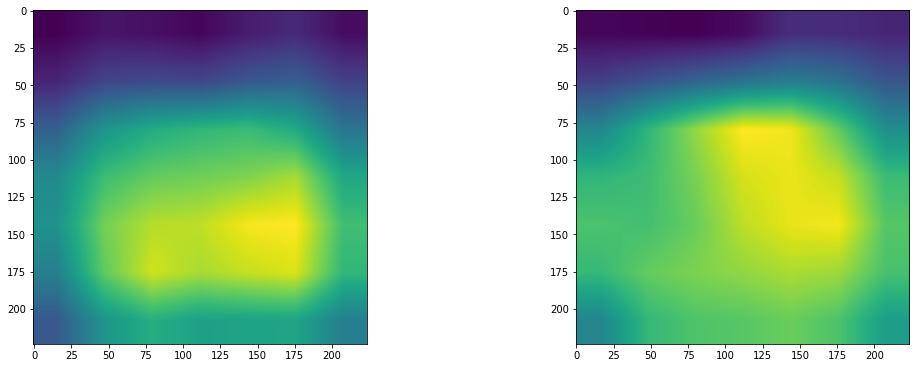

In [9]:
fig = plt.figure(figsize=(15,5),constrained_layout=True)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.imshow(c['Acura_Acura_ILX_3c11ef9e42931b.jpg'])
ax2.imshow(g['Acura_Acura_ILX_3c11ef9e42931b.jpg'])

In [226]:
def custom_mean(arr_in):
    n_samples = sum([x.shape[0] for x in arr_in])
    r = [sum([sum(batch[:,i])/n_samples for batch in arr_in]) for i in range(arr_in[0].shape[-1])]
    return np.array(r)
def custom_var(arr_in, mean_in):
    segmentSeperatedSamples = np.concatenate([[batch[:,sample].flatten() for sample in range(batch.shape[-1])] for batch in arr_in], axis=1)
    # Since mean is already calculated we can utilize it here and save some calculation power
    # Alternativly one could directly return np.var(segmentSeperatedSamples, axis=1)
    # This could introduce rounding risks when calculating the mean
    assert segmentSeperatedSamples.shape[0] == mean_in.shape[0]
    meanNormalized = [segmentSeperatedSamples[i] - mean_in[i] for i in range(segmentSeperatedSamples.shape[0])]
    return np.mean(np.abs(meanNormalized)**2, axis=1)

In [27]:
a = np.random.randint(40000,size=(20000))
print(a)

[25368 34652  5353 ... 12991  7712 20361]


In [28]:
a.sum()

401614025

In [16]:
a.mean()

52742302.86

In [17]:
total = 0
splice = 10
for i in range(int(len(a)/splice)+1):
    s = a[splice*i:splice*(i+1)].sum()
    print(s)
    total += s / len(a)
print(f'Total Mean:{total}')

549215818
521801359
573142598
502151784
490803584
0
Total Mean:52742302.86


In [32]:
a.mean()

47261855.2

In [14]:
a.dtype

dtype('int32')

Using given Segmentation Data.
Loading data from file at ../preGenData/valAllSeg.npz
Using given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMs.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:101: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


Accumulating Statistics for given imgNames.
Generate Statistics Data


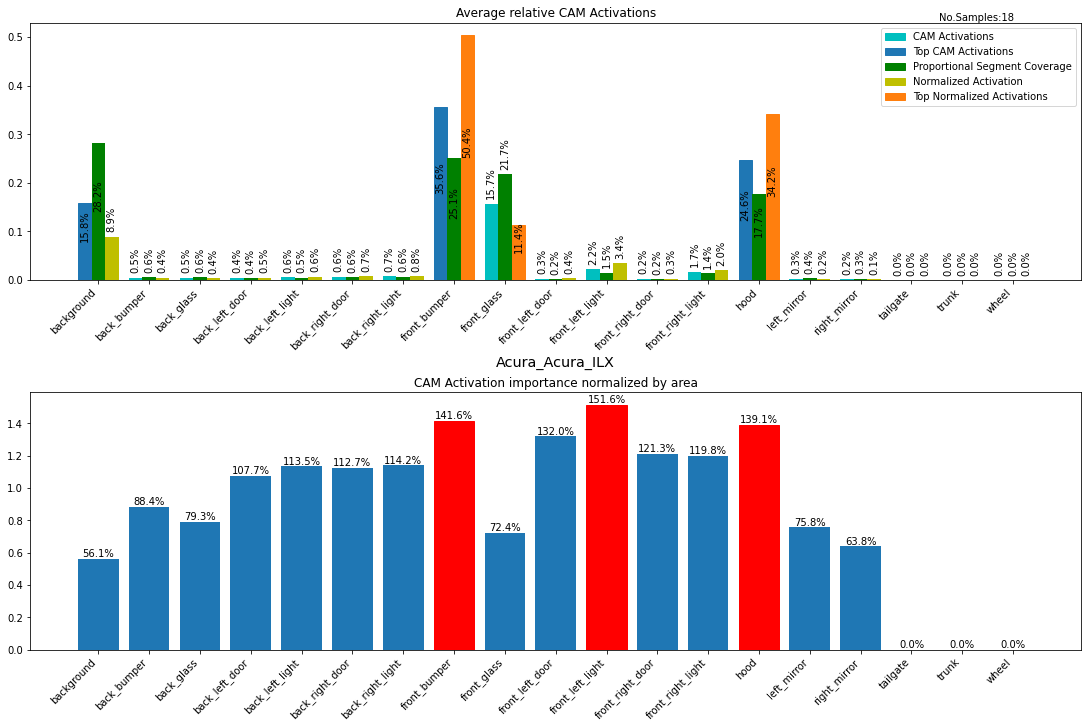

Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_ShowPropArea_AreaNormalized_09_08_2022.jpg
Writing data to file at ./results/dataClasses\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_ShowPropArea_AreaNormalized_09_08_2022.jpg


In [41]:
generate_statistics.generate_statistic_prop_normalized(imgRoot=imgRootVal, camData=camDataGradCAM, segConfig=configSeg,
                       segCheckpoint=checkpointSeg, segData=segDataPath, dataClasses=['Acura_Acura_ILX'],
                        showPercent=True)

Using given Segmentation Data.
Loading data from file at ../preGenData/valAllSeg.npz
Using given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMs.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:101: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


Accumulating Statistics for given imgNames.
Generate Statistics Data
[26699.906 26321.977 26126.756 26078.246 24232.361 25713.094 25079.693
 26092.92  23691.04  25387.277 25903.078 22504.22  26070.11  23275.553
 23460.23  25964.635 26211.377 24673.22 ]
[[ 3199.48445153   106.49514435    98.92998558   110.74506781
    171.01545018   191.20881563   187.26178996  9566.78125119
   4925.26501541    73.60251516   556.06242496    72.65952575
    524.02393246  6779.68093786    79.89300779    56.7964524
      0.             0.             0.        ]
 [ 4382.51578295   124.47172791   113.93264486    86.52448121
    119.65678398   192.15620081   177.06332195  9571.67201202
   4272.91188432    83.11907047   595.75580624    58.82661641
    461.44737977  5901.46273929    83.57210991    96.88806647
      0.             0.             0.        ]
 [ 4119.40253609   142.41315652    98.08269656   148.44119097
    133.15623353   158.51206556   193.40319829  9257.92042425
   4312.88273434    79.31905296 

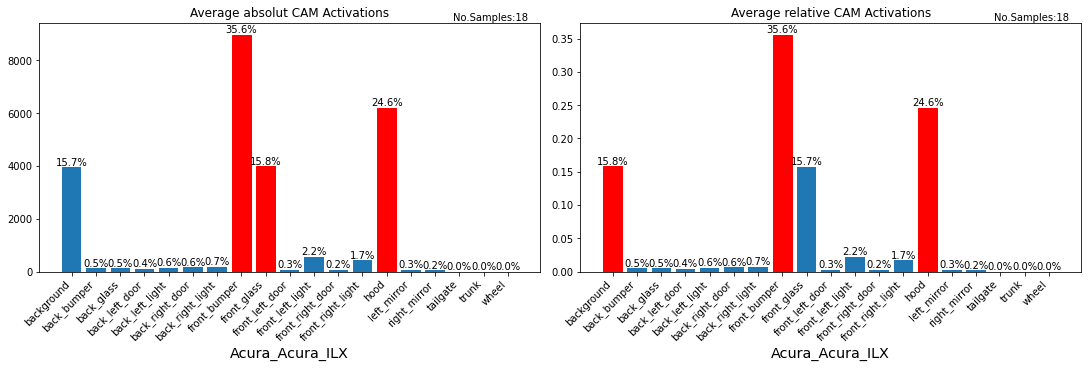

Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_10_08_2022.jpg
Writing data to file at ./results/dataClasses\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_10_08_2022.jpg


In [9]:
generate_statistics.generate_statistic(imgRoot=imgRootVal, camData=camDataGradCAM, segConfig=configSeg,
                       segCheckpoint=checkpointSeg, segData=segDataPath, dataClasses=['Acura_Acura_ILX'])

Using given Segmentation Data.
Loading data from file at ../preGenData/valAllSeg.npz
Using given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMs.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:101: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


Accumulating Statistics for given imgNames.
Generate Statistics Data


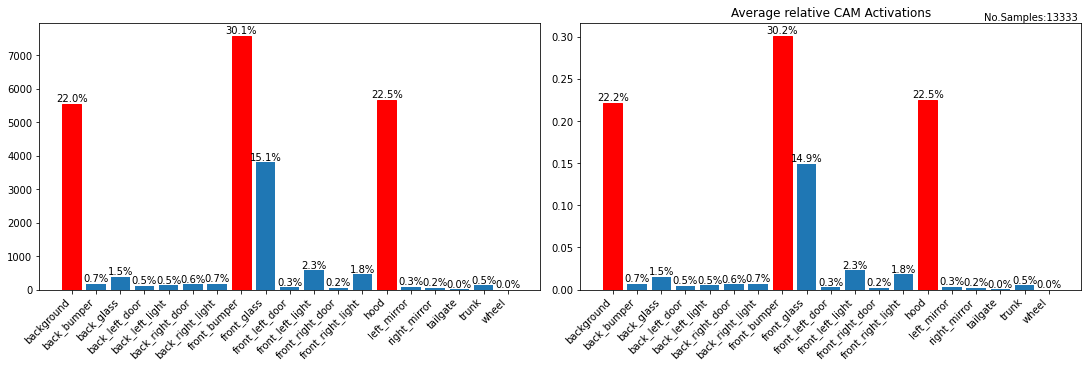

Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\Full_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_10_08_2022.jpg


In [24]:
generate_statistics.generate_statistic(imgRoot=imgRootVal, camData=camDataGradCAM, segConfig=configSeg,
                       segCheckpoint=checkpointSeg, segData=segDataPath)

Using given Segmentation Data.
Loading data from file at ../preGenData/valAllSeg.npz
Using given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMs.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:101: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


Accumulating Statistics for given imgNames.
Generate Statistics Data


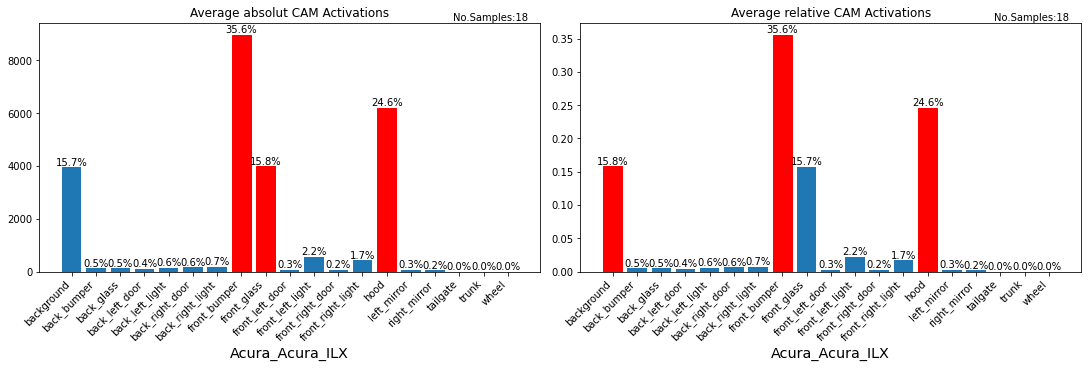

Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_10_08_2022.jpg
Writing data to file at ./results/dataClasses\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_10_08_2022.jpg


In [30]:
generate_statistics.generate_statistic(imgRoot=imgRootVal, camData=camDataGradCAM, segConfig=configSeg,
                       segCheckpoint=checkpointSeg, segData=segDataPath, dataClasses=['Acura_Acura_ILX'])

In [31]:
a = [1,2,3]

In [36]:
a + list((5,))

[1, 2, 3, 5]

In [35]:
a = np.array([2,4,6,8,1,4,81,7,2,66])
b = np.array([9,8,7,6,5,4,3,2,1])
c = np.array([1,2,3,4,5,6,7,8,9])

In [4]:
heapq.nlargest(3, a)

[81, 66, 8]

In [17]:
a[np.argpartition(a, 6)]

array([ 2,  1,  2,  4,  4,  6,  7,  8, 66, 81])

In [13]:
np.argpartition(a, 3)

array([8, 4, 0, 1, 5, 2, 3, 7, 9, 6], dtype=int64)

In [23]:
b[np.argpartition(b, 2)]

array([1, 2, 3, 6, 5, 4, 7, 8, 9])

In [25]:
b[np.argpartition(b, 2)][:3]

array([1, 2, 3])

In [28]:
b[np.argpartition(b, 2)[:3]]

array([1, 2, 3])

In [38]:
c[np.argpartition(-c,3)]

array([8, 9, 7, 6, 5, 2, 4, 3, 1])

In [49]:
c[np.argpartition(c, 8)]

array([2, 1, 3, 4, 5, 6, 7, 8, 9])

In [43]:
c

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [56]:
def 

array([False, False, False,  True, False, False,  True, False, False,
        True])

In [58]:
sorter = np.argsort(a)
highIndices = sorter[np.searchsorted(a, heapq.nlargest(3,a), sorter=sorter)])
lowIndices = sorter[np.searchsorted(a, heapq.nsmallest(3,a), sorter=sorter)])

[6 9 3]
[4 0 0]


In [59]:
heapq.nsmallest(3,a)

[1, 2, 2]

In [60]:
largest = heapq.nlargest(3,a)
smallest = heapq.nsmallest(3,a)

In [62]:
[index for index,val in enumerate(a) if val in largest]

[3, 6, 9]

In [63]:
np.argsort(a)

array([4, 0, 8, 1, 5, 2, 7, 3, 9, 6], dtype=int64)

In [64]:
a[np.argsort(a)]

array([ 1,  2,  2,  4,  4,  6,  7,  8, 66, 81])

In [66]:
a[np.argsort(a)][-3:]

array([ 8, 66, 81])

In [67]:
c = [1,2,3]

In [68]:
c

[1, 2, 3]

In [69]:
c + [np.argsort(a)[:3], np.argsort(a)[-3:], a[np.argsort(a)][:3], a[np.argsort(a)][-3:]]

[1,
 2,
 3,
 array([4, 0, 8], dtype=int64),
 array([3, 9, 6], dtype=int64),
 array([1, 2, 2]),
 array([ 8, 66, 81])]

In [70]:
c + list([np.argsort(a)[:3], np.argsort(a)[-3:], a[np.argsort(a)][:3], a[np.argsort(a)][-3:]])

[1,
 2,
 3,
 array([4, 0, 8], dtype=int64),
 array([3, 9, 6], dtype=int64),
 array([1, 2, 2]),
 array([ 8, 66, 81])]